**Aman Oberoi
St125490**

In [2]:
import numpy as np
import pandas as pd
import os
import mlflow
#tried to trun the auto long off
mlflow.autolog(disable=True)
pd.set_option('compute.use_numexpr', True)

import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import widgets, interactive
import missingno as msno 

from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#all the imports
from models.Regularized_lm import LinearRegression
from models.Regularized_lm import Lasso
from models.Regularized_lm import Ridge
from models.Regularized_lm import ElasticNet

import warnings
warnings.filterwarnings('ignore')

In [2]:
mlflow.set_tracking_uri("http://localhost:5000")
#while deployment change the name from qb
os.environ["LOGNAME"] = "qb"


In [3]:
x_data = pd.read_csv('./data/Cars.csv')
x_data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [4]:
# x_data['owner']=x_data['owner'].astype('category')
x_data['seller_type'].value_counts()

seller_type
Individual          6766
Dealer              1126
Trustmark Dealer     236
Name: count, dtype: int64

**Tried to combine Dealer and Truestmaker Dealer as group**

In [5]:
x_data['owner'].loc[x_data[(x_data['owner'] == 'Fourth & Above Owner') | (x_data['owner'] == 'Third Owner')].index] = 'others'

In [6]:
#few operations
#remove the rows with CNG and Petrol because of diffenece in units
x_data.drop(x_data[(x_data['fuel'] == 'CNG') | (x_data['fuel'] == 'LPG')].index, inplace=True)
x_data['mileage']=x_data['mileage'].apply(lambda x: str(x).split()[0]).astype('float')
x_data['engine'] = x_data['engine'].apply(lambda x: str(x).split()[0]).astype('float')

#remove the torque
x_data.drop(columns = {'torque'}, inplace=True)
# remove the test drive owners
x_data.drop(x_data[x_data['owner']=='Test Drive Car'].index, inplace=True)
x_data['company'] = x_data['name'].apply(lambda x:  x.split()[0])

x_data['max_power']= x_data['max_power'].apply(lambda x: str(x).split()[0])
x_data['max_power'] = x_data['max_power'].replace('bhp', np.NAN).astype('float')

<Axes: xlabel='count', ylabel='name'>

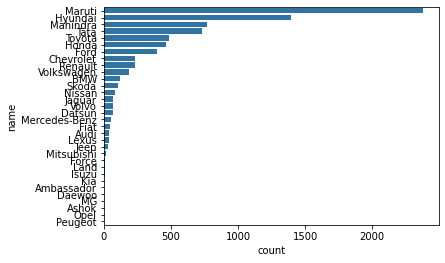

In [7]:
#the number of companies car sold in total 
#this could be a feature to explain the future trajectory in the data
c_per_company =x_data['name'].apply(lambda x:x.split()[0]).value_counts()
sns.barplot(data = c_per_company.to_frame().reset_index(), x = 'count', y = 'name')

**Number of indivisual cars sold by the companies, though this is just and Explaination of Data might not condiser as feature**

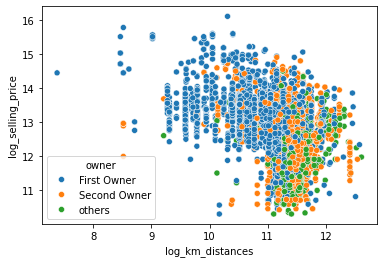

In [8]:
x_data['km_distances']=x_data.groupby(['company','year','owner'])['km_driven'].transform(lambda x:  x.mean())

x_data['log_selling_price'] = x_data['selling_price'].transform('log')
x_data['log_km_distances'] = x_data['km_distances'].transform('log')
sns.scatterplot(data = x_data, x = 'log_km_distances', y = 'log_selling_price', hue="owner")

x_data.drop(columns = {'log_selling_price', 'log_km_distances'}, inplace=True)
#(np.log(x_data['selling_price']), np.log(x_data['km_distances']), hue='owner')

**As the more the car is driven, the lesser the price**

In [9]:
#the specific company is almost null
x_data.drop(6730, inplace=True)

**Droping the row 6730 as it is almost misisng**

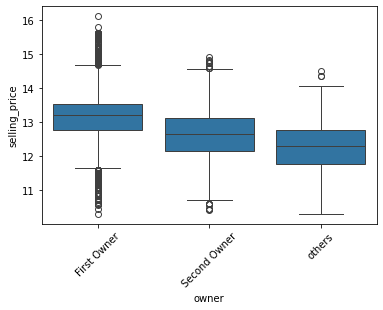

In [10]:
ax=sns.boxplot(data = x_data, x = 'owner', y = x_data['selling_price'].transform('log'))
v=ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

<span style = 'color:black'>**The First Owner has the considerable effect on the selling price owners with lesser driven and are from specific category of owner has the effect.**</span>

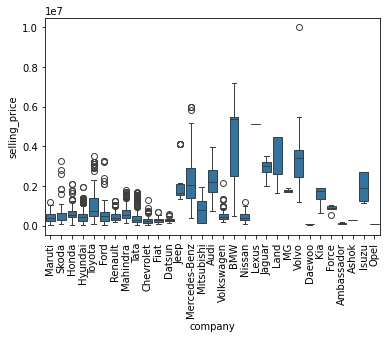

In [11]:
ax=sns.boxplot(data = x_data,x = 'company', y = 'selling_price')
v=ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

<Axes: xlabel='company', ylabel='year'>

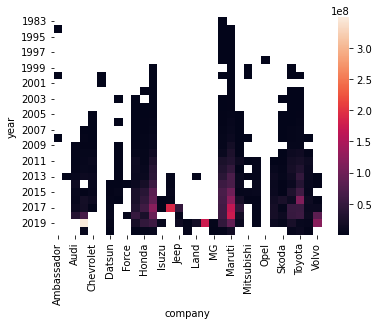

In [12]:
b = x_data[['company', 'year', 'selling_price']].groupby(['company', 'year'])['selling_price'].apply(lambda x: x.sum())
b=b.reset_index()
sns.heatmap(b.pivot(columns = 'company', index = 'year', values = 'selling_price'))
#for example the maruti company have less selling price in 1983 than in 2020 but at the same time maruti have shown in the number of selling price

**Maruti has very less variation in selling price, yet is the most sold car accross the year, so the selling of maruti car is constant because of the range of price is not varying with the given data. At the same time BMW has the sqwness in bounding box feature sample is very less**

In [13]:
#average sale of the company per year 
r=x_data.groupby(['company', 'year'])['name'].apply(lambda x:x.count()).reset_index()

r.set_index('year', inplace=True)
#r[r['company'] == 'Maruti']['name'].plot()
#x_data['company'].unique().shape
company_name = []
n_ = r['company'].value_counts().reset_index()
for k,i in n_.iterrows():
    if i['count'] > 6:
        company_name.append(i['company'])
Company_name = widgets.Dropdown(options= company_name, value=None, description='Company Name:')
def vol_plt(Company_name):
    df2 = r.copy()
    df2 = df2[df2.company == Company_name]
    if len(df2) > 0:
        #pv_df =x.pivot(index='time_id', columns='stock_id', values='target')
        df2.plot()
        plt.show()

interactive(vol_plt,Company_name=Company_name)

interactive(children=(Dropdown(description='Company Name:', options=('Maruti', 'Mahindra', 'Hyundai', 'Tata', …

**pre company car soled select the drop box**

In [14]:
# r = x_data[(x_data['company'] == 'Maruti') & (x_data['year'] == 2014)]
# r[['company', 'name', 'year', 'selling_price']].groupby(['name', 'year'])['selling_price'].apply(lambda x: x.sum())

In [15]:
#log transfrom of training data
# x_data['selling_price'] = x_data['selling_price'].transform('log')

In [16]:
lb= OrdinalEncoder()
t = lb.fit(x_data['transmission'].values.reshape(-1,1))
# with open('transmission.pickle', 'wb') as f:
#     pickle.dump(t, f)

In [17]:
lb= OneHotEncoder()
f = lb.fit(x_data['fuel'].values.reshape(-1, 1))
# with open('fuel.pickle', 'wb') as f_:
#     pickle.dump(f, f_)

In [18]:
lb= OrdinalEncoder()
o = lb.fit(x_data['company'].values.reshape(-1,1))
# with open('company.pickle', 'wb') as f:
#     pickle.dump(o, f)

In [19]:
lb = OneHotEncoder()
b = lb.fit(x_data['owner'].values.reshape(-1, 1))
# with open('owner.pickle', 'wb') as f:
#     pickle.dump(b, f)

In [20]:
lb = OrdinalEncoder()
b_ = lb.fit(x_data['owner'].values.reshape(-1, 1))
# with open('owner_ordinal.pickle', 'wb') as f:
#     pickle.dump(b, f)

**Few embedding done**

In [21]:
#split the training and testing data before hand
x_data['index'] = x_data.index
# test = x_data.loc[round(x_data.shape[0]-x_data.shape[0]*0.20):x_data.shape[0]]
# train = x_data.loc[0:round(x_data.shape[0]-x_data.shape[0]*0.20) - 1]
state = round(np.random.uniform(100))
train, test, y_train, y_test = train_test_split(x_data, x_data['selling_price'], test_size=0.20, random_state= state)


**Early test train split at unifrom random**

In [22]:
train.shape, y_train.shape

((6421, 15), (6421,))

In [23]:
number_sold = train.groupby(['company'])['name'].apply(lambda  x: x.value_counts()).to_frame().reset_index().rename(columns = {'level_1':'name', 'name':'number_sold'})
train = pd.merge(number_sold, train, on = ['company', 'name'], how = 'right')

number_sold = test.groupby(['company'])['name'].apply(lambda  x: x.value_counts()).to_frame().reset_index().rename(columns = {'level_1':'name', 'name':'number_sold'})
test = pd.merge(number_sold, test, on = ['company', 'name'], how = 'right')


**Let us see the impact of numbers of vayring car sold each year by the each company**

<Axes: title={'center': 'Maruti Ritz VDi'}, xlabel='year'>

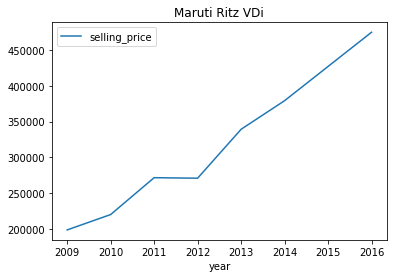

In [24]:
#because of short of time could make interactive plots
r2 = train.groupby(['company', 'name','year'])['selling_price'].apply(lambda x:x.mean()).reset_index()
r2[(r2['company'] == 'Maruti') & (r2['name'] == 'Maruti Ritz VDi')][['year','selling_price']].set_index('year').plot(title = 'Maruti Ritz VDi')

<Axes: >

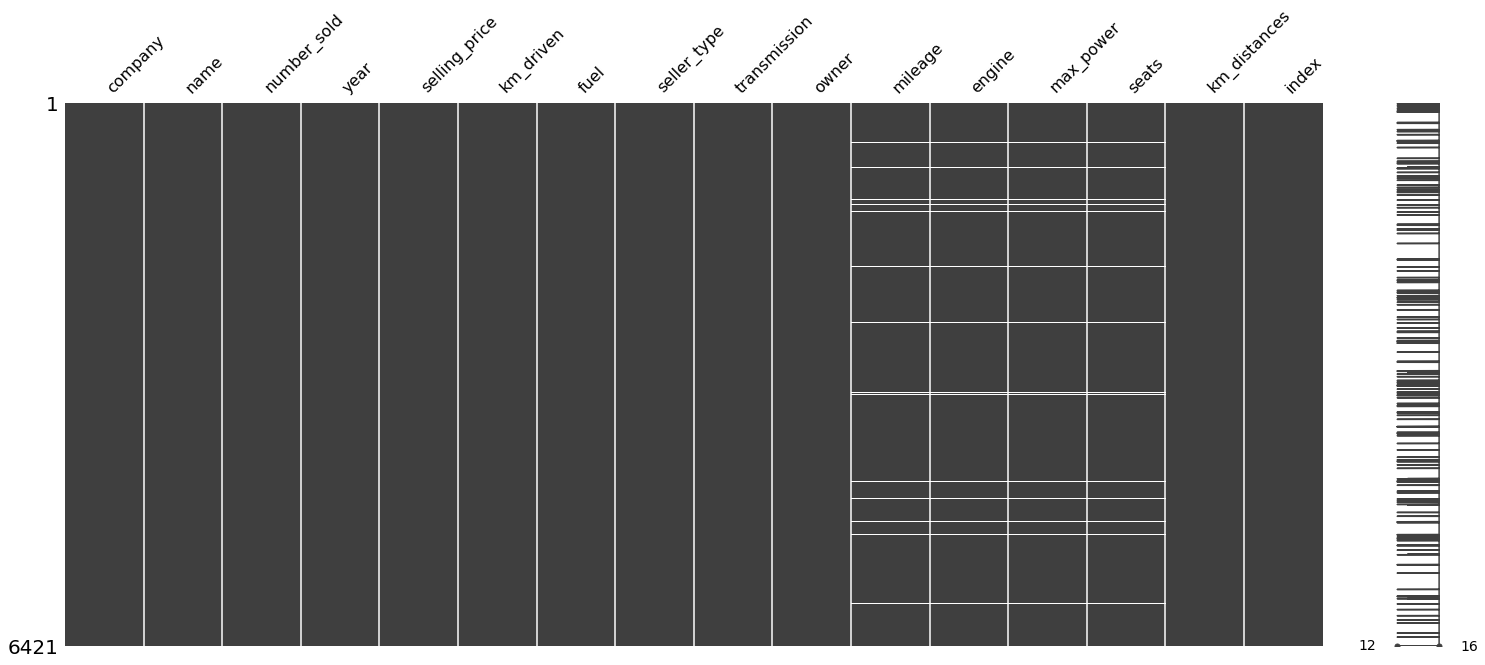

In [25]:
msno.matrix(train)

**The missingness looks like not missing at random. The missing data might have some pattren by some covariates 
or eaxtral causal impact, which out of the scope of this notebook, we did some basic imputation**

In [26]:
def imputation_d(x):
    if x.shape[0] > 0:            
        x['engine']=x['engine'].apply(lambda x: str(x).split()[0]).astype('float')
        x['index'] = x.index
        r=x.groupby('company')['engine'].apply(lambda x: x.fillna(x.median()))
        x.set_index(['company', 'index'], inplace=True)
        x['engine'] = r
        x.reset_index(inplace=True)
        
        #even though the full distribution is centered to mean but so mean is close to median , 
        #but here filling up each distribution with median as per the company
        # filling missing values for milage
        x['index'] = x.index
        r = x.groupby('company')['mileage'].apply(lambda x: x.fillna(x.mean()))
        x.set_index(['company', 'index'], inplace=True)
        x['mileage'] = r
        x.reset_index(inplace=True)
        
        x['binned_engine']=pd.cut(x['engine'], [1, 1000, 1500, 1800, x['engine'].max()], labels = list(range(1,5))[::-1])
        #drop all the na columns
        x.drop(x[x['binned_engine'].isna()].index, inplace=True)
        x['binned_engine'] = x.binned_engine.astype('int')
        
        #the distribution of max_power is not mean centered as whole so each group will be assumed (because the data is MNAR) to have median of each 
        #maxpower engine produced by companies
        x['index'] = x.index
        r = x.groupby('company')['max_power'].apply(lambda x: x.fillna(x.mean()))
        x.set_index(['company', 'index'], inplace=True)
        x['max_power'] = r
        x.reset_index(inplace=True)
        
        # seat is not the ordinal data if that so enconding required
        # filling na values by filling in with a company not sure if this make sense 
        ix=x[x['seats'].isna()].index
        for i in ix:
            name =x.loc[i]['company']
            min_seats = x[x['company'] == name]['seats'].min()
            max_seats = x[x['company'] == name]['seats'].max()
            if not pd.isna(min_seats):
                x['seats'].loc[i]=round(max_seats/min_seats) 
        return x

In [27]:
train = imputation_d(train)
test = imputation_d(test)

<Axes: xlabel='binned_engine', ylabel='count'>

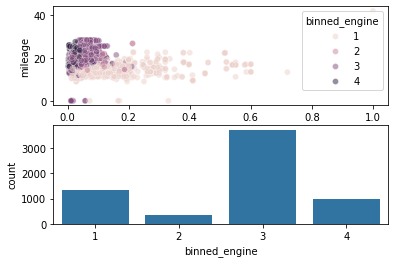

In [28]:
#binning
fig, ax=plt.subplots(2)
sns.scatterplot(ax = ax[0],data = train , x ='selling_price', y= 'mileage', hue = 'binned_engine', alpha=0.5)
bin_counts = train['binned_engine'].value_counts().reset_index()
sns.barplot(ax = ax[1], data = bin_counts, x= 'binned_engine', y = 'count')


**Engine can be considered as ordinal data, because the better the engine by cc is the higher the price, we tries to perform ordinal linear encoding by binning the ranges of engines per cc**

In [29]:
def features(x, encoding='one_hot', phase='Traning', required_unscale = True):
    #x['avg_yearly'] = x.groupby(['company','year'])['selling_price'].transform('mean')
    x['co_cc']=x.groupby(['company'])['year'].transform(lambda x: sum(x-x.min())).astype('float')
    x['_num_sales'] = x.groupby(['company', 'year'])['name'].transform('count')
    r=x.groupby(['company', 'year'])['name'].apply(lambda x:x.count()).reset_index() 
        
    x['transmission'] = pd.Series(t.transform(x['transmission'].values.reshape(-1,1)).astype('int').flatten())
    
    m = f.transform(np.array(x['fuel']).reshape(-1,1)).toarray()
    x[['Diesel','petrol']] = pd.DataFrame.from_records(m , columns = x['fuel'].unique())

    if encoding == 'one_hot':
        m = b.transform(np.array(x['owner']).reshape(-1,1)).toarray()
        x[['firstowner', 'secondowner', 'others']] = pd.DataFrame.from_records(m, columns = x['owner'].unique())
    elif encoding == 'oridinal':
        x['_owner_encoded'] = pd.Series(b_.transform(x['owner'].values.reshape(-1,1)).astype('int').flatten())
#     x['_owner_encoded']=x.groupby('company')['_owner_encoded'].transform(lambda x: x/x.max())
    
    x['_company'] = o.transform(x['company'].values.reshape(-1,1)).astype('int')

    r = x.groupby(['company', 'year'])['seats'].value_counts()
    x.set_index(['company', 'year', 'seats'], inplace = True)
    x['_seats_in_year'] = r
    x.reset_index(inplace=True)
    
    r = x.groupby(['company', 'seller_type'])['selling_price'].apply(np.mean)
    x.set_index(['company', 'seller_type'], inplace=True)
    x['avg_sellertype'] = r
    x.reset_index(inplace=True)
    
###scaling features
    x['km_distances']=x.groupby(['company', 'year','owner'])['km_driven'].transform(lambda x: x.mean())
    x['km_distances'] = x['km_distances'].transform('log')
    
    global s_, s_p
    fs = ['km_distances', 'avg_sellertype', 'max_power','selling_price', 'mileage', 'engine', '_num_sales', '_seats_in_year']
    if phase =='Training':
        s = StandardScaler()
        selling_price = x['selling_price']
        s_ = s.fit(x[fs].values)
        x[fs] = s_.transform(x[fs].values)
        if required_unscale:
            s_1 = StandardScaler()
            s_p = s_1.fit(selling_price.values.reshape(-1, 1))
            return x, selling_price,s_p
    elif phase == 'Testing':
            selling_price = x['selling_price']
            x[fs] = s_.transform(x[fs].values)
            if required_unscale:
                return x, selling_price,s_p
    #per year sold cars 
    
    return x
    

**Basic Feature Engineering ,**
* the older year model have lesser price than recent model accroding the data
* Number of Sales by the company
* One hot encoding of other features
* Km distances the range as it travled, more or less
* Few standard scaling
**Tried more features but have impact on predictability**

In [30]:
train['selling_price'] = train['selling_price']
test['selling_price'] = test['selling_price']
train, unscaled_train, scaler_train  = features(train, phase='Training')
test, unscaled_test,scaler_test = features(test, phase='Testing')

In [31]:
x_target = train['selling_price']
y_target = test['selling_price']

In [32]:
train[['Diesel', 'petrol', 'firstowner', 'others', 'secondowner']] =train[['Diesel', 'petrol', 'firstowner', 'others','secondowner']].astype('int')

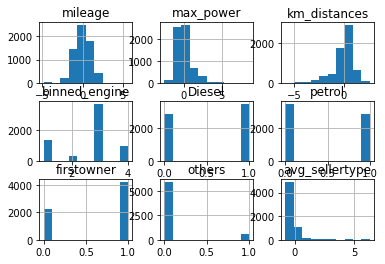

In [33]:
drop_columns = ['seats','owner',
                'seller_type','number_sold','name',
                'index', 'company', 'fuel', 'transmission', 'km_driven', 'selling_price','_seats_in_year','_company'
               ,'_num_sales','secondowner', 'co_cc', 'engine', 'year']
train.drop(columns = drop_columns, inplace=True)
test.drop(columns = drop_columns,inplace=True)
ax=train.hist()
feature_names = train.columns

**<span style="color:blue">Further Work on Assignment2</span>**

In [34]:
import sys

def str_to_class(classname):
    return getattr(sys.modules[__name__],classname)

global _score 
_score = 0

In [35]:
#without replacement sample , because of memeory and computational issues.
train=train.sample(1000)
x_target = x_target.loc[train.index]
test = test.sample(670)
y_target = y_target.loc[test.index]
unscaled_train=unscaled_train.loc[train.index]
unscaled_test = unscaled_test.loc[test.index]

In [36]:
train['binned_engine']=train['binned_engine'].astype('category')
test['binned_engine'] = test['binned_engine'].astype('category')

**some encoding for linear regression previous model was non linear**

In [58]:
def train_validate(regs, params, function, per_eta, regularise = False):
    for reg in regs:
        #params = {"method": "batch", "lr":0.1, 'eta':0.003, 'regularization':None, '_names':feature_names}
        #mlflow.start_run(run_name=f"method-{params['method']}-lr-{params['lr']}-reg-{reg}-eta-{params['eta']}", nested=True)
        mlflow.start_run(run_name=f"method-{params['method']}-lr-{params['lr']}-reg-{reg}", nested=True)
        print("="*5, reg, "="*5)
        ########
        type_of_regression = str_to_class(reg)#Ridge, Lasso, ElasticNet
        #use params reg_ in order to run regularizers
        params['reg_'] = reg
        model = type_of_regression(**params)  
    
        
        scores = model.fit(train.values, x_target.values)
        yhat = model.predict(test.values)
        mse  = model.mse(ytrue = y_target, ypred = yhat)
        r_ = model.r_square(ytrue = y_target, ypred = yhat)
        if per_eta:
            function(scores, mse,r_ ,params['eta'])
        if regularise:
            coef = model._coef()
            function(scores, mse, r_, params ,coef=coef, model= model)
        else:
            function(scores, mse,r_, params)
            
            
        print("Test MSE: ", mse)
        mlflow.log_metric(key="test_mse", value=mse)

        signature = mlflow.models.infer_signature(train, model.predict(train))
        mlflow.sklearn.log_model(model, artifact_path='model', signature=signature)

    # #######
        mlflow.end_run()


**with momentum and without momentum**

In [59]:
#
scores_di = []
def f(scores, mse, r_,eta):
    scores_di.append((scores, mse, eta,r_))
#etas params
etas = [0.1, 0.9 , None]
params = {'method':'batch', 'lr':0.01, 'reg_':False,'regularization':False, 'eta':None, '_names':feature_names}
for eta in etas:
    params['eta'] = eta
    print('Momentum rate:', eta)
    train_validate(['LinearRegression'], params, f, per_eta = True)
        
# params = {"method":"batch", "lr":0.01, 'eta':None,'regularization':False, '_names':feature_names}
# scores = train_validate(['LinearRegression'], params, f, per_eta = False)


Momentum rate: 0.1
===== LinearRegression =====
(1000, 9)


2024/09/07 22:09:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://localhost:5000/#/experiments/0/runs/41fc4a344d4f44eeb733f31c36587d7b.
2024/09/07 22:09:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
2024/09/07 22:09:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-1 at: http://localhost:5000/#/experiments/0/runs/ca48223994b54b468b2b386197c2d3f5.
2024/09/07 22:09:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
2024/09/07 22:09:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-2 at: http://localhost:5000/#/experiments/0/runs/11fce1053a1b4a00bc238eb789b5668b.
2024/09/07 22:09:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Test MSE:  0.17856472811929175


2024/09/07 22:09:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run method-batch-lr-0.01-reg-LinearRegression at: http://localhost:5000/#/experiments/0/runs/2e2e846a22064b7e908a3da6813d0e62.
2024/09/07 22:09:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Momentum rate: 0.9
===== LinearRegression =====
(1000, 9)


2024/09/07 22:09:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://localhost:5000/#/experiments/0/runs/a4884e34b4e54100920234d2065dbb68.
2024/09/07 22:09:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
2024/09/07 22:09:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-1 at: http://localhost:5000/#/experiments/0/runs/dc0fcdd04217415f8d6488278ef14444.
2024/09/07 22:09:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
2024/09/07 22:09:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-2 at: http://localhost:5000/#/experiments/0/runs/c9cd70ff088f46ebb009197ed3908225.
2024/09/07 22:09:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Test MSE:  0.17746693291430232


KeyboardInterrupt: 

In [63]:
scores_di[0][3]

0.8241369376397415

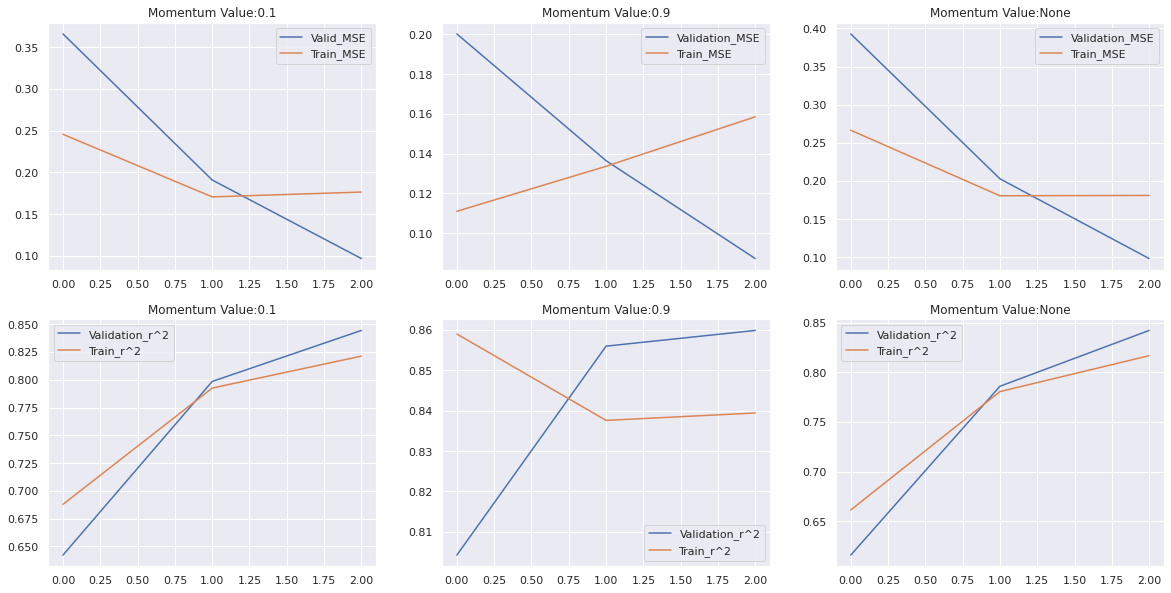

In [42]:
sns.set_theme()
fig, ax=plt.subplots(2,3, figsize=(20,10))
ax[0,0].plot(scores_di[0][0]['val_score'], label = 'Valid_MSE')
ax[0,0].plot(scores_di[0][0]['train_score'], label = 'Train_MSE')
ax[0,0].set_title('Momentum Value:{}'.format(scores_di[0][2]))
ax[0,0].legend()


ax[0,1].plot(scores_di[2][0]['val_score'], label = 'Validation_MSE')
ax[0,1].plot(scores_di[2][0]['train_score'], label = 'Train_MSE')
ax[0,1].set_title('Momentum Value:{}'.format(scores_di[2][2]))
ax[0,1].legend()

ax[0,2].plot(scores_di[4][0]['val_score'], label = 'Validation_MSE')
ax[0,2].plot(scores_di[4][0]['train_score'], label = 'Train_MSE')
ax[0,2].set_title('Momentum Value:{}'.format(scores_di[4][2]))
ax[0,2].legend()


ax[1,0].plot(scores_di[0][0]['r_sq_val'], label = 'Validation_r^2')
ax[1,0].plot(scores_di[0][0]['r_sq_train'], label = 'Train_r^2')
ax[1,0].set_title('Momentum Value:{}'.format(scores_di[0][2]))
ax[1,0].legend()

ax[1,1].plot(scores_di[2][0]['r_sq_val'], label='Validation_r^2')
ax[1,1].plot(scores_di[2][0]['r_sq_train'], label ='Train_r^2')
ax[1,1].set_title('Momentum Value:{}'.format(scores_di[2][2]))
ax[1,1].legend()

ax[1,2].plot(scores_di[4][0]['r_sq_val'], label = 'Validation_r^2')
ax[1,2].plot(scores_di[4][0]['r_sq_train'], label = 'Train_r^2')
ax[1,2].set_title('Momentum Value:{}'.format(scores_di[4][2]))
ax[1,2].legend()



**The plot indexes might vary because of the output of mlflow, mlflow is returning the 'none' as parameter but the effect is shown on the mlflow graph, furthermore we can see the impact of eta variable the last and first eta is not having that much damp in the learing rate i.e 0.9 and None is almost the same where 0.1 is the effect of momentum is that it avoids local minimum from each direction**

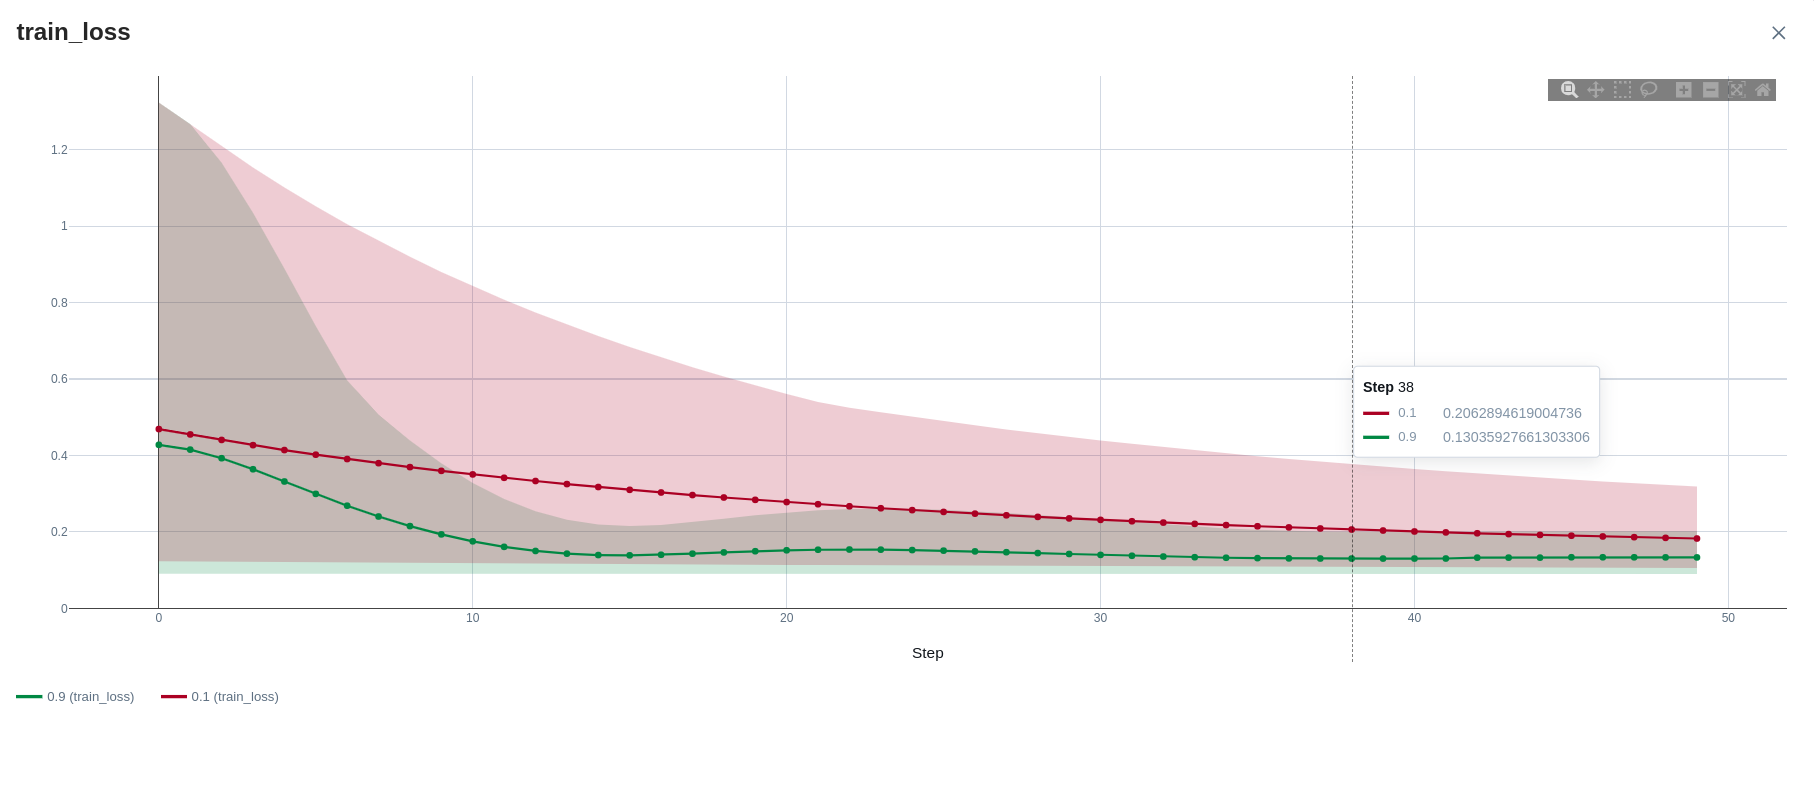

In [56]:
from IPython.display import Image
Image(filename='./Ml_flow_/With and Without momentum/eta_effect.png')

In [43]:
#test scores
df_m = pd.DataFrame([[scores_di[0][1], scores_di[2][1], scores_di[4][1]],[scores_di[0][3], scores_di[2][3], scores_di[4][3]]],
                  index=pd.Index(['MSE', 'R^2'], name='Scores:'),
                  columns=['With Momentum_eta_0.9', 'With Momentum_eta_0.8','Without Momentum'])
df_m.style

,With Momentum_eta_0.9,With Momentum_eta_0.8,Without Momentum
Scores:,,,
MSE,0.178565,0.177467,0.181540
R^2,0.822752,0.823841,0.819799


**Momentum does not impact the converges of error that much**

**Output can be messed up with index because of mlflow callbacks**

**Comparing Initialisation**

In [54]:
scores_di = []
def f(scores, mse,r_ ,etas=None):
    scores_di.append((scores, mse, etas, r_))

params = {'method':'batch', 'lr':0.1, 'eta':None, 'reg_':False,'regularization':None, 'xaviar':True ,'_names':feature_names}
train_validate(['LinearRegression'], params, f, per_eta = False)
    
params = {"method": "batch", "lr":0.1, 'eta':None, 'reg_':False,'regularization':None, '_names':feature_names}
scores = train_validate(['LinearRegression'], params, f, per_eta = False)

===== LinearRegression =====


2024/09/07 22:04:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://localhost:5000/#/experiments/0/runs/fe8b42d47300498285e19848e37ab204.
2024/09/07 22:04:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
2024/09/07 22:04:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-1 at: http://localhost:5000/#/experiments/0/runs/79a78c7e7f6140428a8cc591cd9cd433.
2024/09/07 22:04:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
2024/09/07 22:04:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-2 at: http://localhost:5000/#/experiments/0/runs/4da2874b3cb446bfa889a88678e9cc48.
2024/09/07 22:04:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Test MSE:  0.177863824739062


2024/09/07 22:05:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run method-batch-lr-0.1-reg-LinearRegression at: http://localhost:5000/#/experiments/0/runs/b11b0440c89e40e4bc24d336e0d1cc27.
2024/09/07 22:05:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


===== LinearRegression =====
(1000, 9)
LinearRegression


2024/09/07 22:05:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://localhost:5000/#/experiments/0/runs/d962c87c77894de595c61cba4883cf2e.
2024/09/07 22:05:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


LinearRegression


2024/09/07 22:05:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-1 at: http://localhost:5000/#/experiments/0/runs/089d2914646149fa89d186d230cb43a2.
2024/09/07 22:05:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


LinearRegression


2024/09/07 22:05:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-2 at: http://localhost:5000/#/experiments/0/runs/b068bb292daa4f68a1cdb98eeda646cc.
2024/09/07 22:05:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Test MSE:  0.1769602877021204


2024/09/07 22:05:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run method-batch-lr-0.1-reg-LinearRegression at: http://localhost:5000/#/experiments/0/runs/6269da68dc934200abc013abb57c705e.
2024/09/07 22:05:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Text(0.5, 1.0, 'Zero init R^2')

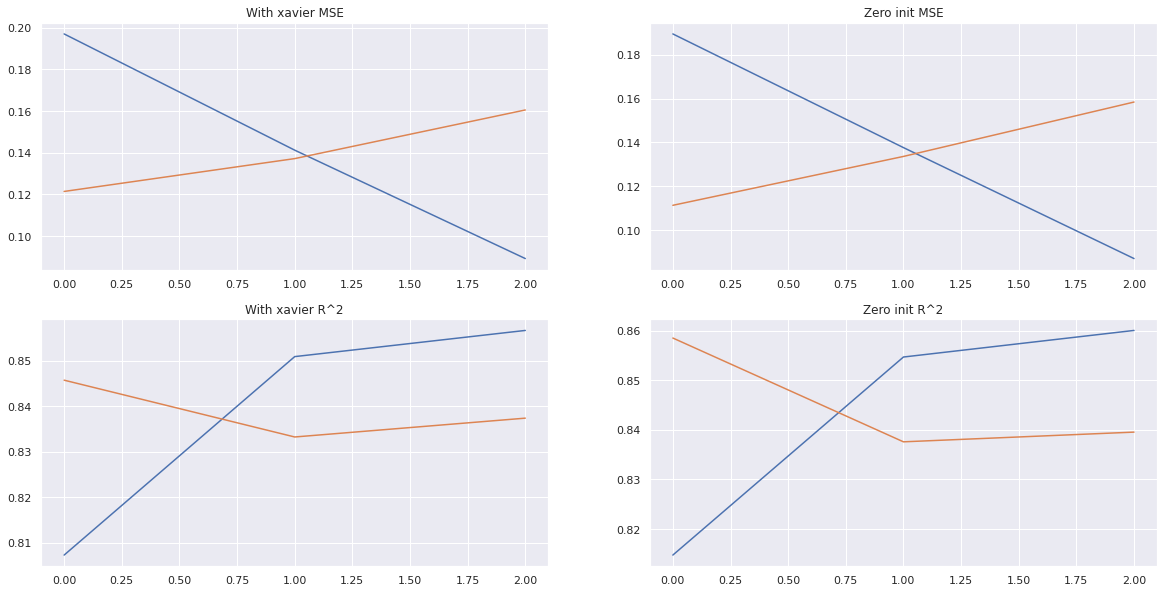

In [46]:
sns.set_theme()

fig, ax=plt.subplots(2,2, figsize = (20,10))

ax[0,0].plot(scores_di[0][0]['val_score'])
ax[0,0].plot(scores_di[0][0]['train_score'])
ax[0,0].set_title('With xavier MSE')


ax[0,1].plot(scores_di[1][0]['val_score'])
ax[0,1].plot(scores_di[1][0]['train_score'])
ax[0,1].set_title('Zero init MSE')

ax[1,0].plot(scores_di[0][0]['r_sq_val'])
ax[1,0].plot(scores_di[0][0]['r_sq_train'])
ax[1,0].set_title('With xavier R^2')

ax[1,1].plot(scores_di[1][0]['r_sq_val'])
ax[1,1].plot(scores_di[1][0]['r_sq_train'])
ax[1,1].set_title('Zero init R^2')


**As the paramter space is small it is hard to tell the distiction by batched, the initial batches deviates at more or less same rate. The goal of Xavier is to have constant variance across epoches and longer learning and avoid vanishing gradient problem. Let us take the help on mlflow in order to find clear picture**

In [47]:
#test scores
df_r = pd.DataFrame([[scores_di[0][1], scores_di[1][1]],[scores_di[0][3], scores_di[1][3]]],
                  index=pd.Index(['MSE', 'R^2'], name='Scores:'),
                  columns=['With xaviar','Zero_init'])
df_r.style

,With xaviar,Zero_init
Scores:,,
MSE,0.180234,0.176960
R^2,0.821095,0.824344


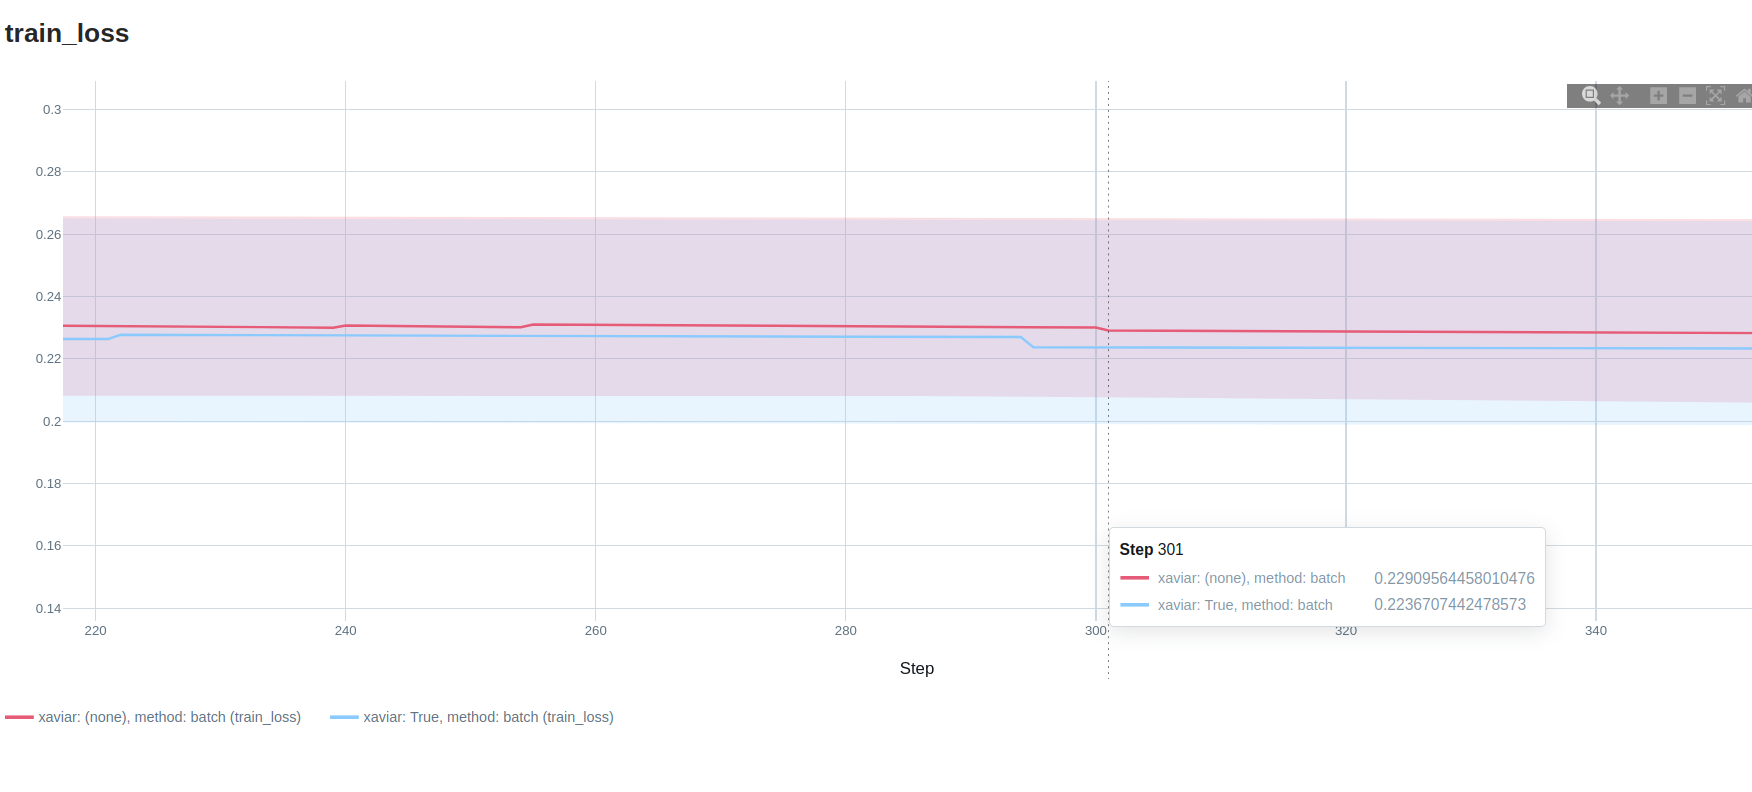

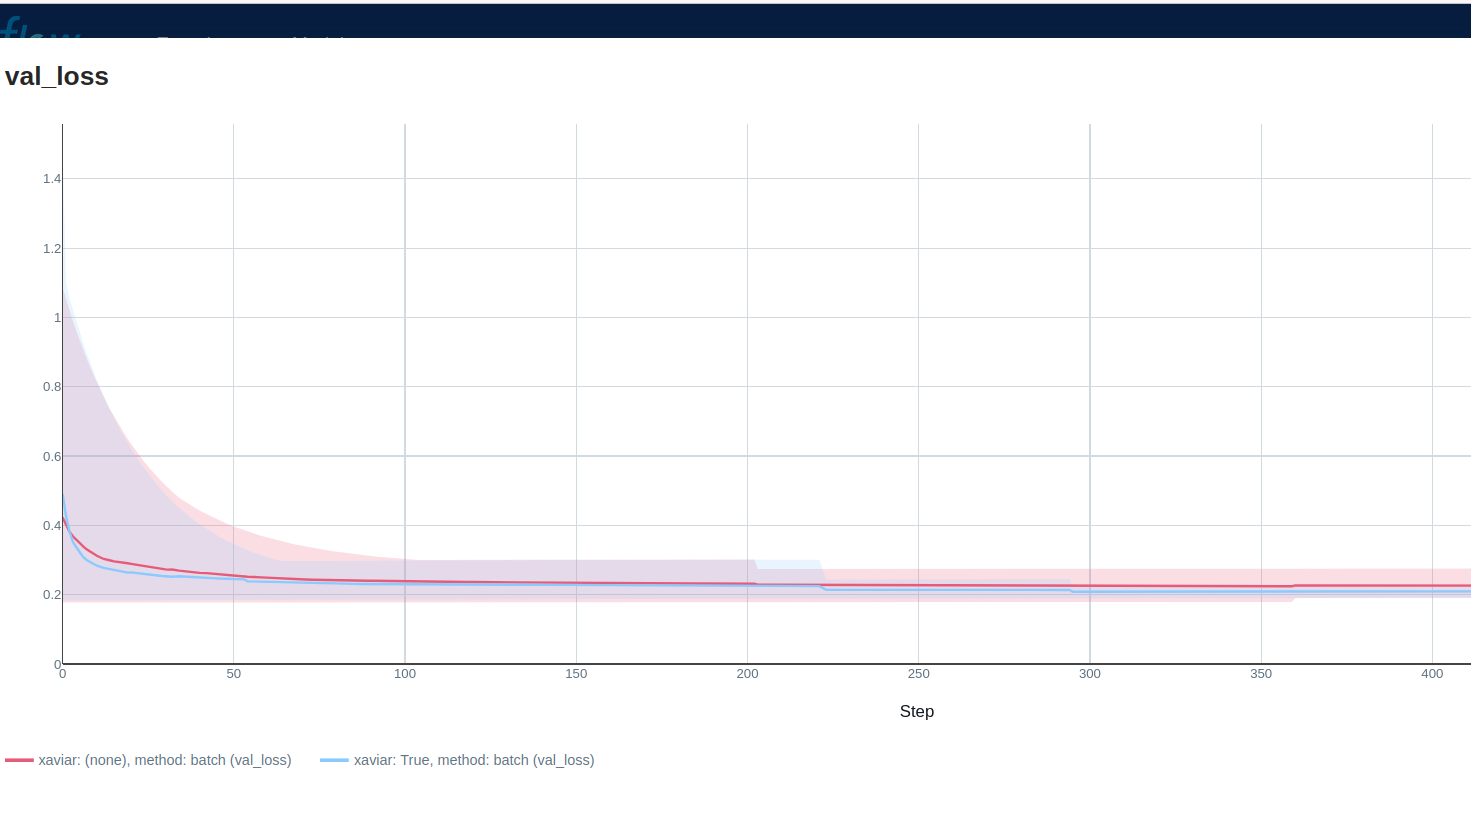

In [74]:
from IPython.display import display
x=Image(filename='./Ml_flow_/Init_comp/Xavier_zero.png')
y=Image(filename='./Ml_flow_/Init_comp/Xavier_2.png')
display(x, y)

**As we can see the impact of longer training in blue trajectory, this show that xavier does not allow the solution to fall into local minimum. Furthermore we do not have enough degrees of freedom in parameter space like deep neural network to have larger devation in learning**

**Comparing learning rates**

In [55]:
scores_di = []
def f(scores, mse, r_,etas=None):
    scores_di.append((scores, mse, etas,r_, lr))
params = {'method':'batch', 'lr':0.01, 'regularization':None, 'reg_':None, 'eta':None,'_names':feature_names}

lrs = [0.01,0.001,0.0001]
for lr in lrs:
    params['lr'] = lr
    train_validate(['LinearRegression'], params, f, per_eta = False)

===== LinearRegression =====
(1000, 9)
LinearRegression


2024/09/07 22:06:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://localhost:5000/#/experiments/0/runs/37f72ce11cf3472e8ba06d477906d9d3.
2024/09/07 22:06:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


LinearRegression


2024/09/07 22:06:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-1 at: http://localhost:5000/#/experiments/0/runs/5e9a58e5a1034d9ca2c699b0fc69efa7.
2024/09/07 22:06:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


LinearRegression


2024/09/07 22:06:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-2 at: http://localhost:5000/#/experiments/0/runs/1ebcc7bc103340d2bc9798e16e9bdd04.
2024/09/07 22:06:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Test MSE:  0.181539852846196


2024/09/07 22:06:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run method-batch-lr-0.01-reg-LinearRegression at: http://localhost:5000/#/experiments/0/runs/335ed2df228c48ffb3583477639fb893.
2024/09/07 22:06:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


===== LinearRegression =====
(1000, 9)
LinearRegression


2024/09/07 22:06:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://localhost:5000/#/experiments/0/runs/9572dc0de2f941659703206a01cc1717.
2024/09/07 22:06:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


LinearRegression


2024/09/07 22:06:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-1 at: http://localhost:5000/#/experiments/0/runs/c2f2dd5cd7a344b1a840fb01f457ae62.
2024/09/07 22:06:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


LinearRegression


2024/09/07 22:06:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-2 at: http://localhost:5000/#/experiments/0/runs/8782e7332079486491b0e75cba245d9f.
2024/09/07 22:06:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Test MSE:  0.6714263337356001


2024/09/07 22:06:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run method-batch-lr-0.001-reg-LinearRegression at: http://localhost:5000/#/experiments/0/runs/8b9f0c6637274260abd29f030de5e698.
2024/09/07 22:06:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


===== LinearRegression =====
(1000, 9)
LinearRegression


2024/09/07 22:06:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://localhost:5000/#/experiments/0/runs/110b7bcbf7034265a18cf1619ffe0581.
2024/09/07 22:06:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


LinearRegression


2024/09/07 22:06:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-1 at: http://localhost:5000/#/experiments/0/runs/2e7588d77c244f5c86e278ab38f78bf1.
2024/09/07 22:06:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


LinearRegression


2024/09/07 22:06:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-2 at: http://localhost:5000/#/experiments/0/runs/e111c78a665f4e30bf64f1f24aa98021.
2024/09/07 22:06:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Test MSE:  0.9612384385638396


2024/09/07 22:06:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run method-batch-lr-0.0001-reg-LinearRegression at: http://localhost:5000/#/experiments/0/runs/958e35a647424c159188f18b249986fa.
2024/09/07 22:06:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Text(0.5, 1.0, 'lr rate:0.0001 r^2')

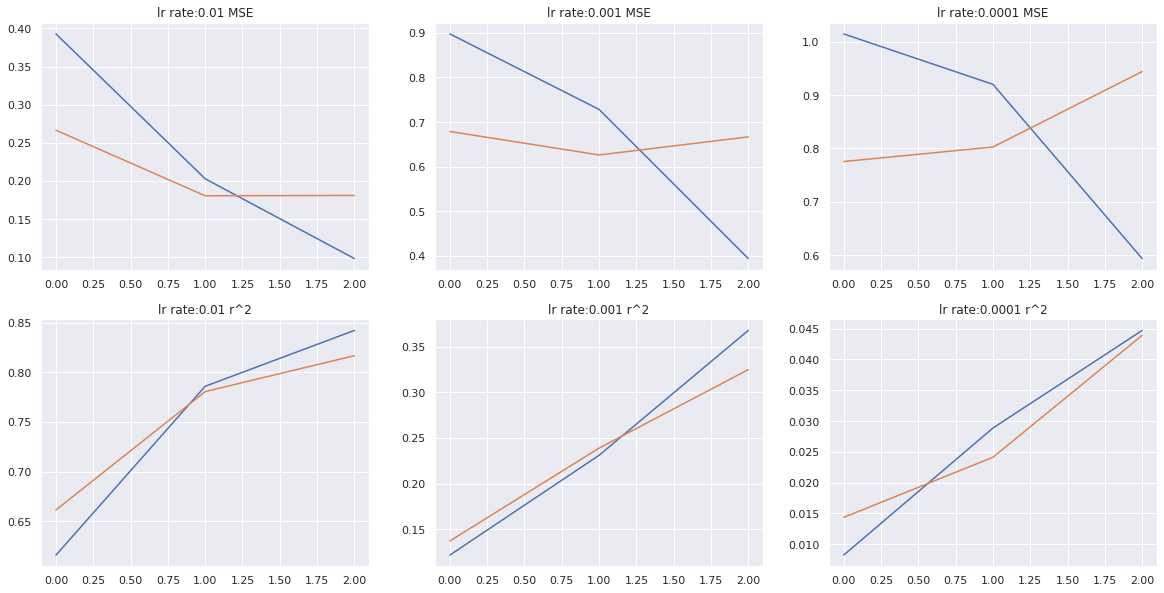

In [50]:
sns.set_theme()

fig, ax=plt.subplots(2,3, figsize = (20,10))
ax[0,0].plot(scores_di[0][0]['val_score'])
ax[0,0].plot(scores_di[0][0]['train_score'])
ax[0,0].set_title('lr rate:{} MSE'.format(scores_di[0][4]))


ax[0,1].plot(scores_di[1][0]['val_score'])
ax[0,1].plot(scores_di[1][0]['train_score'])
ax[0,1].set_title('lr rate:{} MSE'.format(scores_di[1][4]))


ax[0,2].plot(scores_di[2][0]['val_score'])
ax[0,2].plot(scores_di[2][0]['train_score'])
ax[0,2].set_title('lr rate:{} MSE'.format(scores_di[2][4]))


ax[1,0].plot(scores_di[0][0]['r_sq_val'])
ax[1,0].plot(scores_di[0][0]['r_sq_train'])
ax[1,0].set_title('lr rate:{} r^2'.format(scores_di[0][4]))


ax[1,1].plot(scores_di[1][0]['r_sq_val'])
ax[1,1].plot(scores_di[1][0]['r_sq_train'])
ax[1,1].set_title('lr rate:{} r^2'.format(scores_di[1][4]))


ax[1,2].plot(scores_di[2][0]['r_sq_val'])
ax[1,2].plot(scores_di[2][0]['r_sq_train'])
ax[1,2].set_title('lr rate:{} r^2'.format(scores_di[2][4]))


In [51]:
df_LR = pd.DataFrame([[scores_di[0][1], scores_di[1][1], scores_di[2][1]],[scores_di[0][3], scores_di[1][3], scores_di[2][3]]],
                  index=pd.Index(['MSE', 'R^2'], name='Scores:'),
                  columns=['LR-0.1','LR-0.01', 'LR-0.001'])
df_LR.style

,LR-0.1,LR-0.01,LR-0.001
Scores:,,,
MSE,0.181540,0.671426,0.961238
R^2,0.819799,0.333524,0.045848


**For this sample lower learning rate controls overfitting in above batch plot it is evident enough higher learning rate have seems have overfit all the above model and that intersting to find though the MSE is better for LR-0.1 but have worst impact on out of sample. <span style="color:blue">Here LR-0.001 does not have better out of sample but we cant measure unless model is facing larges sample size and stream of data .</span>**

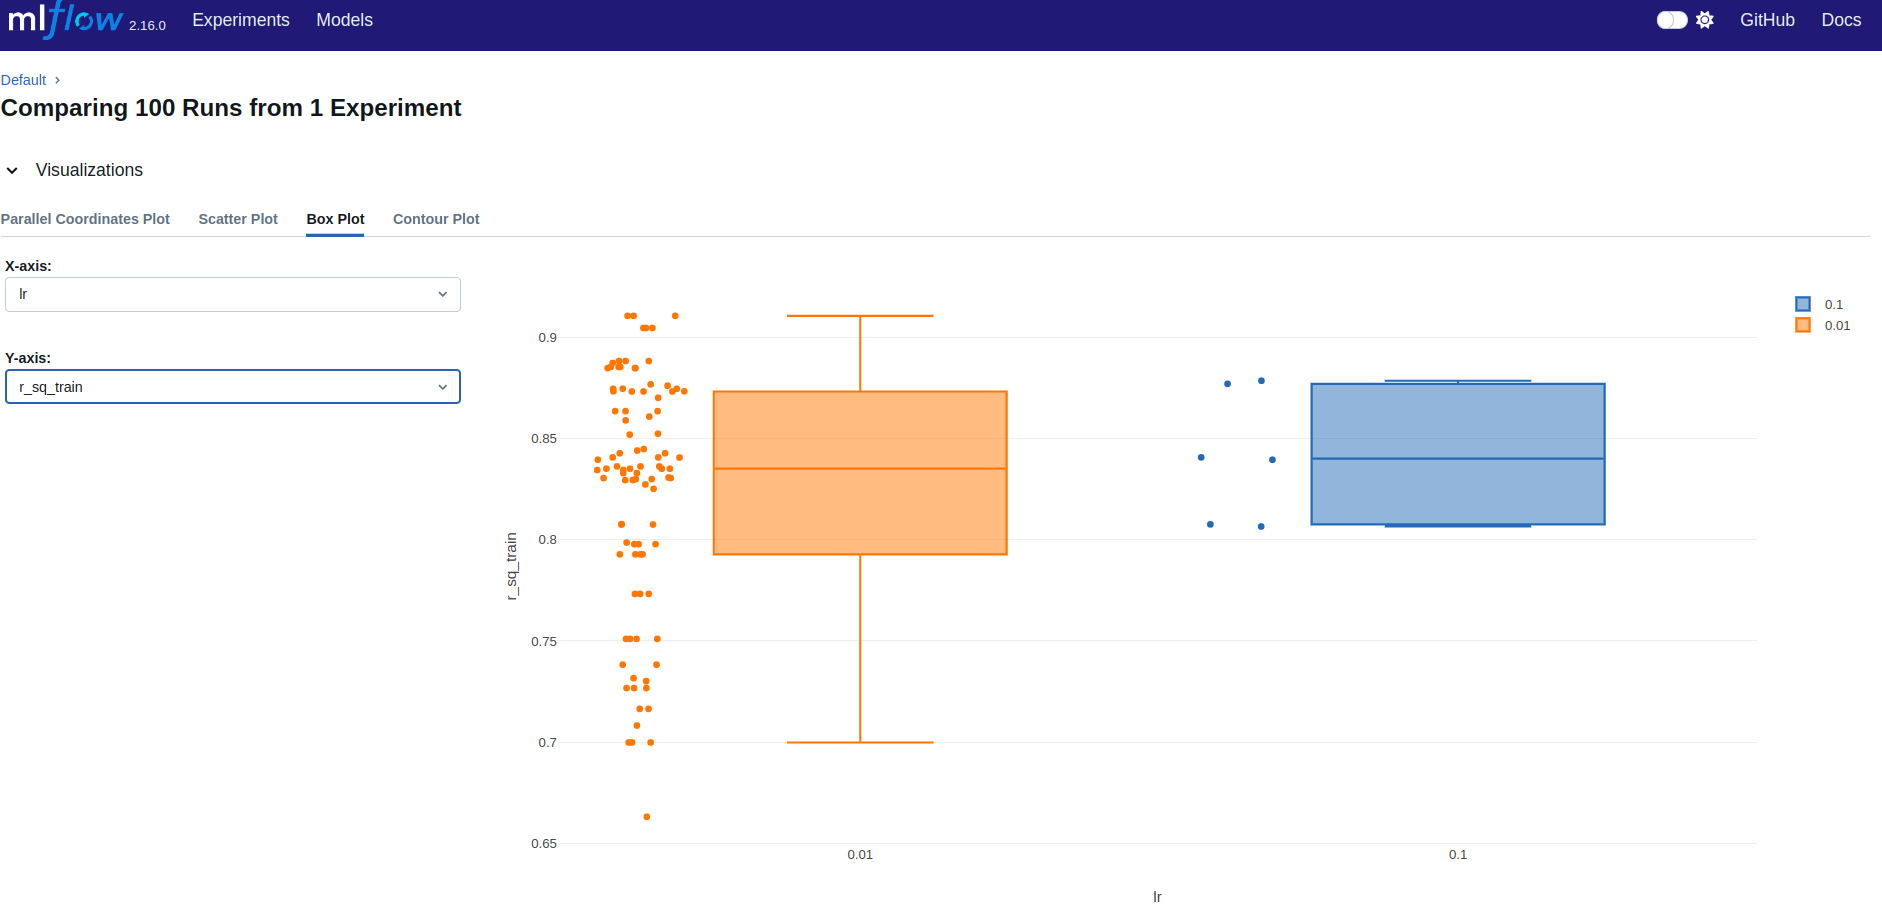

In [83]:
Image(filename='./Ml_flow_/lr_rate/lr_ops.png')

**mlflow again return none for the last learning rate but we can se the impact of lr with r^2 more variation and better generalisation**

**comparing batches**

In [56]:
scores_di = []
#here for stochastic batches the mse was showing index error so changes were made mse, as the sample size is one.
methods = ['sto', 'mini', 'batch']
def f(scores, mse, r_, method):
    scores_di.append((scores, mse,r_, method))
for m in methods:
    params = {'method':m, 'lr':0.01,'regularization':None, 'eta':None,'_names':feature_names}
    train_validate(['LinearRegression'], params, f, per_eta = False)

===== LinearRegression =====
(1000, 9)
LinearRegression


2024/09/07 22:07:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://localhost:5000/#/experiments/0/runs/69dc18a96b6e4f7f994f10c91ec510e9.
2024/09/07 22:07:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


LinearRegression


2024/09/07 22:07:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-1 at: http://localhost:5000/#/experiments/0/runs/9a2daa7499c448c494dc664c75d1cbfa.
2024/09/07 22:07:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


LinearRegression


2024/09/07 22:07:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-2 at: http://localhost:5000/#/experiments/0/runs/242536c658ae48349461f3456aff000b.
2024/09/07 22:07:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Test MSE:  121.29421363021298


KeyboardInterrupt: 

Text(0.5, 1.0, 'r^2 batch')

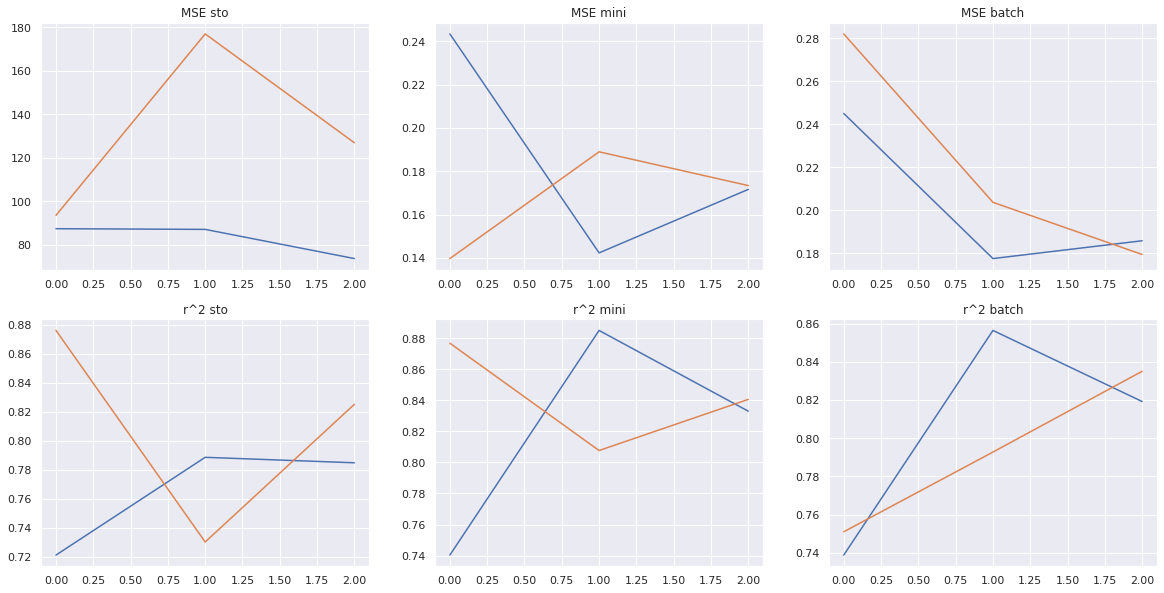

In [85]:
sns.set_theme()

fig, ax=plt.subplots(2,3, figsize = (20,10))
ax[0,0].plot(scores_di[0][0]['val_score'])
ax[0,0].plot(scores_di[0][0]['train_score'])
ax[0,0].set_title('MSE {}'.format(scores_di[0][3]['method']))


ax[0,1].plot(scores_di[1][0]['val_score'])
ax[0,1].plot(scores_di[1][0]['train_score'])
ax[0,1].set_title('MSE {}'.format(scores_di[1][3]['method']))


ax[0,2].plot(scores_di[2][0]['val_score'])
ax[0,2].plot(scores_di[2][0]['train_score'])
ax[0,2].set_title('MSE {}'.format(scores_di[2][3]['method']))


ax[1,0].plot(scores_di[0][0]['r_sq_val'])
ax[1,0].plot(scores_di[0][0]['r_sq_train'])
ax[1,0].set_title('r^2 {}'.format(scores_di[0][3]['method']))


ax[1,1].plot(scores_di[1][0]['r_sq_val'])
ax[1,1].plot(scores_di[1][0]['r_sq_train'])
ax[1,1].set_title('r^2 {}'.format(scores_di[1][3]['method']))


ax[1,2].plot(scores_di[2][0]['r_sq_val'])
ax[1,2].plot(scores_di[2][0]['r_sq_train'])
ax[1,2].set_title('r^2 {}'.format(scores_di[2][3]['method']))

**It is intresting to see how stochastic batches behaves , not only control overfitting but also have almost the smiliar r^2, for this sample linear model could have better explaination for each features**

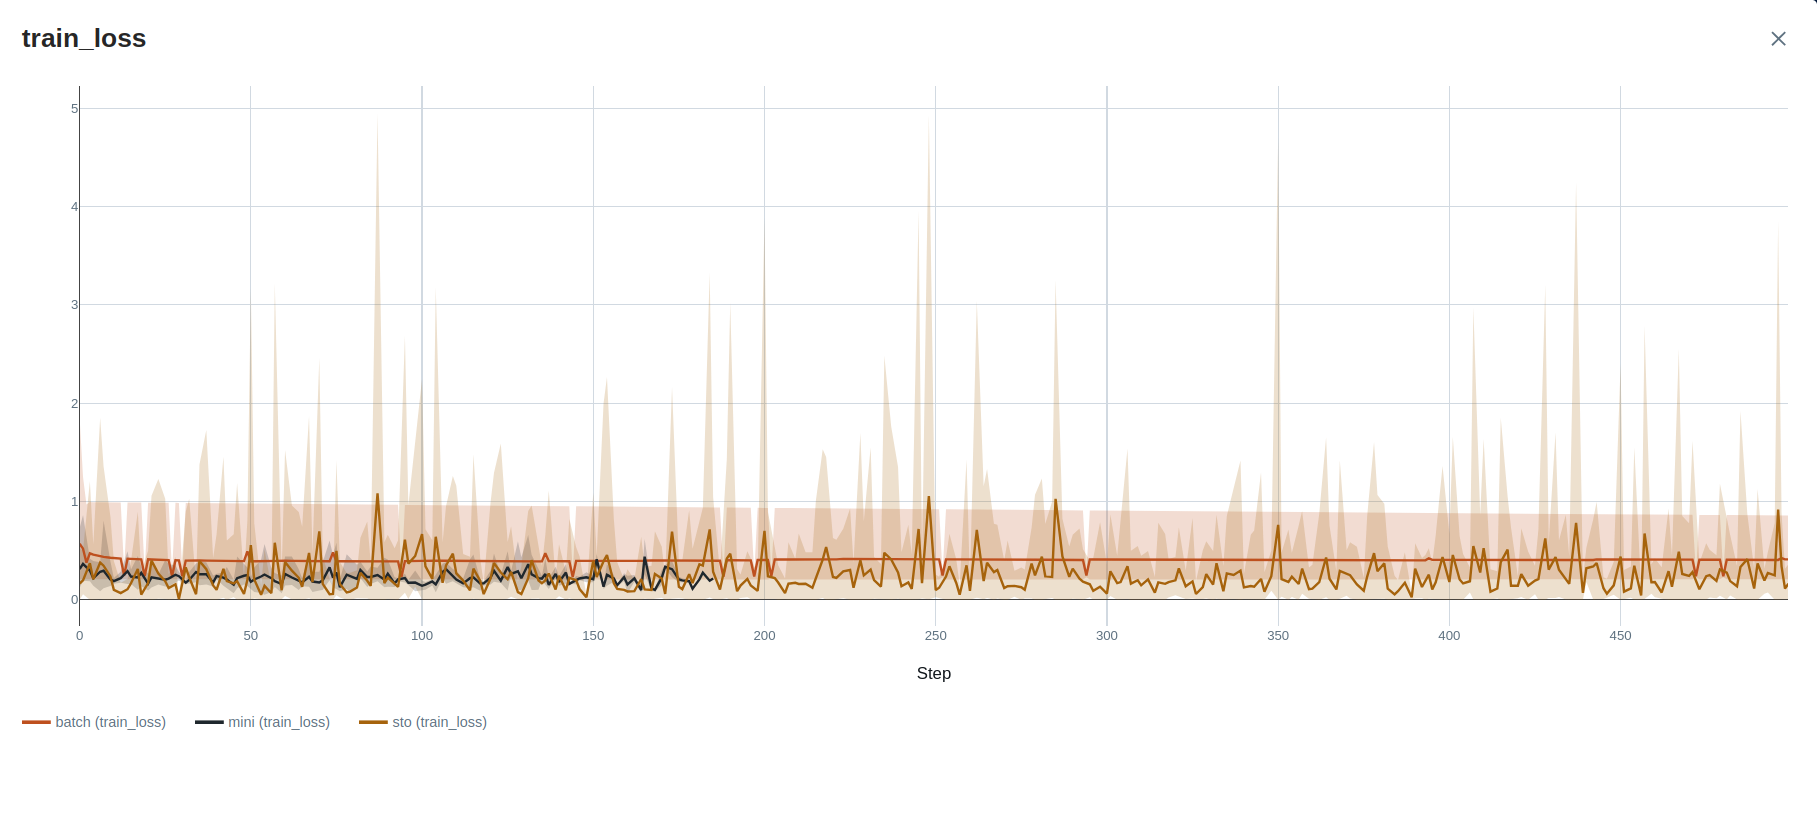

In [87]:
Image(filename='./Ml_flow_/Batches_comp/Batches.png')

**With mlflow it shows the devaiation and uncertainity , that concludes that stochastoc batching runs for longer and introduce randomness, which can be used larger and sparse data sets, the results are very intersting.**

In [88]:
df_LR = pd.DataFrame([[scores_di[0][1], scores_di[1][1], scores_di[2][1]],[scores_di[0][2], scores_di[1][2], scores_di[2][2]]],
                  index=pd.Index(['MSE', 'R^2'], name='Scores:'),
                  columns=['Stochastic','Mini batch', 'Batching'])
df_LR.style

,Stochastic,Mini batch,Batching
Scores:,,,
MSE,92.218589,0.119810,0.121235
R^2,0.799239,0.825245,0.823166


**Stochastic  batch have higher uncertainity as sample size was one but have better r^2**

**Comparing  Regularizers**

In order to run Regularizer , few twiking has been done in LinearRegression class, set the regularization parameter, reg models are not set to work with momentum at the same time but we can compare them on same sample at mlflow

In [57]:
#lasso and redigd regression and Normal, tried with 'sto' and 'batch' deu to the properties of linear model
from models.Regularized_lm import Lasso
from models.Regularized_lm import Ridge
from models.Regularized_lm import ElasticNet

scores_di = []
regs = ["Ridge", "Lasso", "ElasticNet"]
def f(scores, mse, r_, method, coef, model):
    scores_di.append((scores, mse,r_, method, coef, model))

l = [0.001, 0.01, 0.1]
for i in l:
    params = {'lr':0.01, 'l':i,'method':'sto'}
    params['regularization'] = True
    train_validate(regs, params, f, per_eta = False, regularise=True)

===== Ridge =====
(1000, 9)


2024/09/07 22:08:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://localhost:5000/#/experiments/0/runs/12cbb1ea14d74b1eaf062f2d1828238b.
2024/09/07 22:08:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
2024/09/07 22:08:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-1 at: http://localhost:5000/#/experiments/0/runs/a0db4485fe5445c8922da62af14990b2.
2024/09/07 22:08:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
2024/09/07 22:08:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-2 at: http://localhost:5000/#/experiments/0/runs/b11b550ac9bf43a59c7cd8e33af1a528.
2024/09/07 22:08:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Test MSE:  0.6714263337355999


2024/09/07 22:08:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run method-sto-lr-0.01-reg-Ridge at: http://localhost:5000/#/experiments/0/runs/231ef7f08d174e1697b99d4220889e9b.
2024/09/07 22:08:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


===== Lasso =====
(1000, 9)


2024/09/07 22:08:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://localhost:5000/#/experiments/0/runs/55ce6dfadd8f43d2a041063430794626.
2024/09/07 22:08:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
2024/09/07 22:08:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-1 at: http://localhost:5000/#/experiments/0/runs/8c86a4e4806648789187703e8cb8932c.
2024/09/07 22:08:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
2024/09/07 22:08:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-2 at: http://localhost:5000/#/experiments/0/runs/a13df91efc4e4c8d84b9bc9047f7f7b3.
2024/09/07 22:08:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Test MSE:  0.6714263337355999


2024/09/07 22:08:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run method-sto-lr-0.01-reg-Lasso at: http://localhost:5000/#/experiments/0/runs/a089a1e06ec542dbb6a0972f4e9c1b85.
2024/09/07 22:08:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


===== ElasticNet =====
(1000, 9)


2024/09/07 22:08:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://localhost:5000/#/experiments/0/runs/01ee01e5a22e4bafa06ecc3312e340d8.
2024/09/07 22:08:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
2024/09/07 22:08:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-1 at: http://localhost:5000/#/experiments/0/runs/823dca2f99ab47529e56e36239efcf9f.
2024/09/07 22:08:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
2024/09/07 22:09:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-2 at: http://localhost:5000/#/experiments/0/runs/fae77b3ae5fb41fabac7939432353e21.
2024/09/07 22:09:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Test MSE:  0.6714263337356001


2024/09/07 22:09:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run method-sto-lr-0.01-reg-ElasticNet at: http://localhost:5000/#/experiments/0/runs/3462090b213946908f9ddbe4d72f1f0f.
2024/09/07 22:09:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


===== Ridge =====
(1000, 9)


2024/09/07 22:09:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://localhost:5000/#/experiments/0/runs/69aa7c8826c044cca540030e98a0e627.
2024/09/07 22:09:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
2024/09/07 22:09:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-1 at: http://localhost:5000/#/experiments/0/runs/c77b1bd07143444cb616441ebad7ca88.
2024/09/07 22:09:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
2024/09/07 22:09:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-2 at: http://localhost:5000/#/experiments/0/runs/19538933a8ee4a4cab10b99da06a220c.
2024/09/07 22:09:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Test MSE:  0.6714263337355999


2024/09/07 22:09:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run method-sto-lr-0.01-reg-Ridge at: http://localhost:5000/#/experiments/0/runs/421fe1b5e3c04a4e964fcbd4a2895fff.
2024/09/07 22:09:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


===== Lasso =====
(1000, 9)


2024/09/07 22:09:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://localhost:5000/#/experiments/0/runs/556e57518f634205b696151786907bf9.
2024/09/07 22:09:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


KeyboardInterrupt: 

In [42]:
scores_di[0][5].__class__.__name__
# coefs = pd.DataFrame(
#          scores_di[0][4], index=feature_names).reset_index(names = ['features', 'm']) 
res = {'coef':[], 'reg_type':[],'class':[]}
for i in range(9):
    res['coef'].append(scores_di[i][4])
    res['reg_type'].append(scores_di[i][3]['l'])
    res['class'].append(scores_di[i][5].__class__.__name__)
res=pd.DataFrame(res)

In [43]:
R=res[res['class'] == 'Ridge']
p=pd.DataFrame(R['coef'].apply(pd.Series)).T
L2=p.set_index(train.columns).rename(columns = {0:'0.2', 3:'0.1', 6:'0.01'} )
L2=L2.reset_index()

<Axes: xlabel='0.01', ylabel='index'>

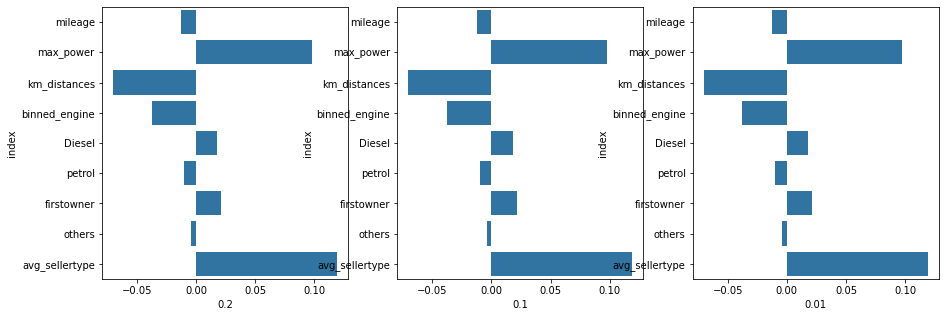

In [44]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
sns.barplot(data = L2, x = '0.2', y = 'index', ax =ax[0])
sns.barplot(data = L2, x = '0.1', y = 'index', ax = ax[1])
sns.barplot(data = L2, x = '0.01', y = 'index', ax = ax[2])

In [42]:
R=res[res['class'] == 'Lasso']
p=pd.DataFrame(R['coef'].apply(pd.Series)).T
L1=p.set_index(train.columns).rename(columns = {1:'0.2', 4:'0.1', 7:'0.01'} )
L1=L1.reset_index()

<Axes: xlabel='0.01', ylabel='index'>

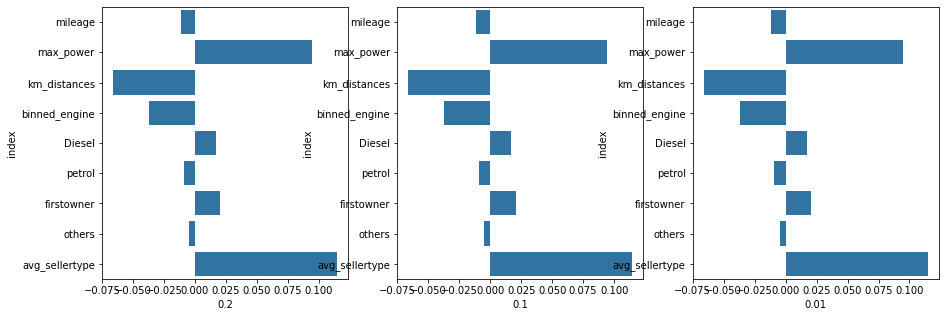

In [43]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
sns.barplot(data = L1, x = '0.2', y = 'index', ax =ax[0])
sns.barplot(data = L1, x = '0.1', y = 'index', ax = ax[1])
sns.barplot(data = L1, x = '0.01', y = 'index', ax = ax[2])

In [49]:
R=res[res['class'] == 'ElasticNet']
p=pd.DataFrame(R['coef'].apply(pd.Series)).T
Elastic=p.set_index(train.columns).rename(columns = {2:'0.2', 5:'0.1', 8:'0.01'} )
Elastic.reset_index(inplace=True)

<Axes: xlabel='0.01', ylabel='index'>

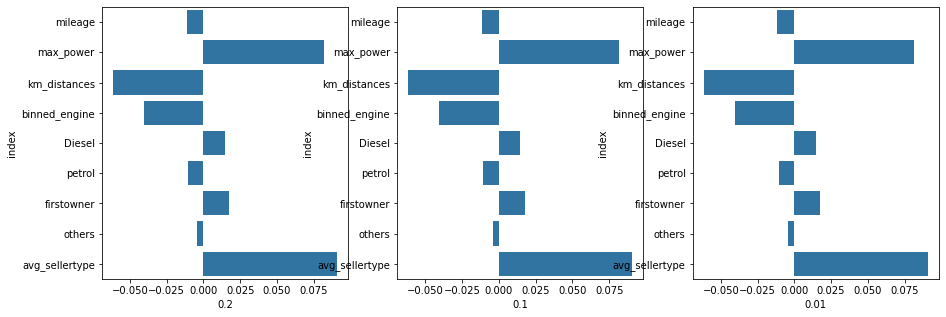

In [50]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
sns.barplot(data = Elastic, x = '0.2', y = 'index', ax =ax[0])
sns.barplot(data = Elastic, x = '0.1', y = 'index', ax = ax[1])
sns.barplot(data = Elastic, x = '0.01', y = 'index', ax = ax[2])

**There seeems to be no significance of Regularization at the defined paremeters there could be multiple issues, linear models are suspected to multi-colinearity and , the sample size of data is very low, best solution is to use L2 Regularizer because of the high value finds the best group of features because of the sparsity in data. Let us try to use ploynomial regression in-order to compare further and see how results depects.**

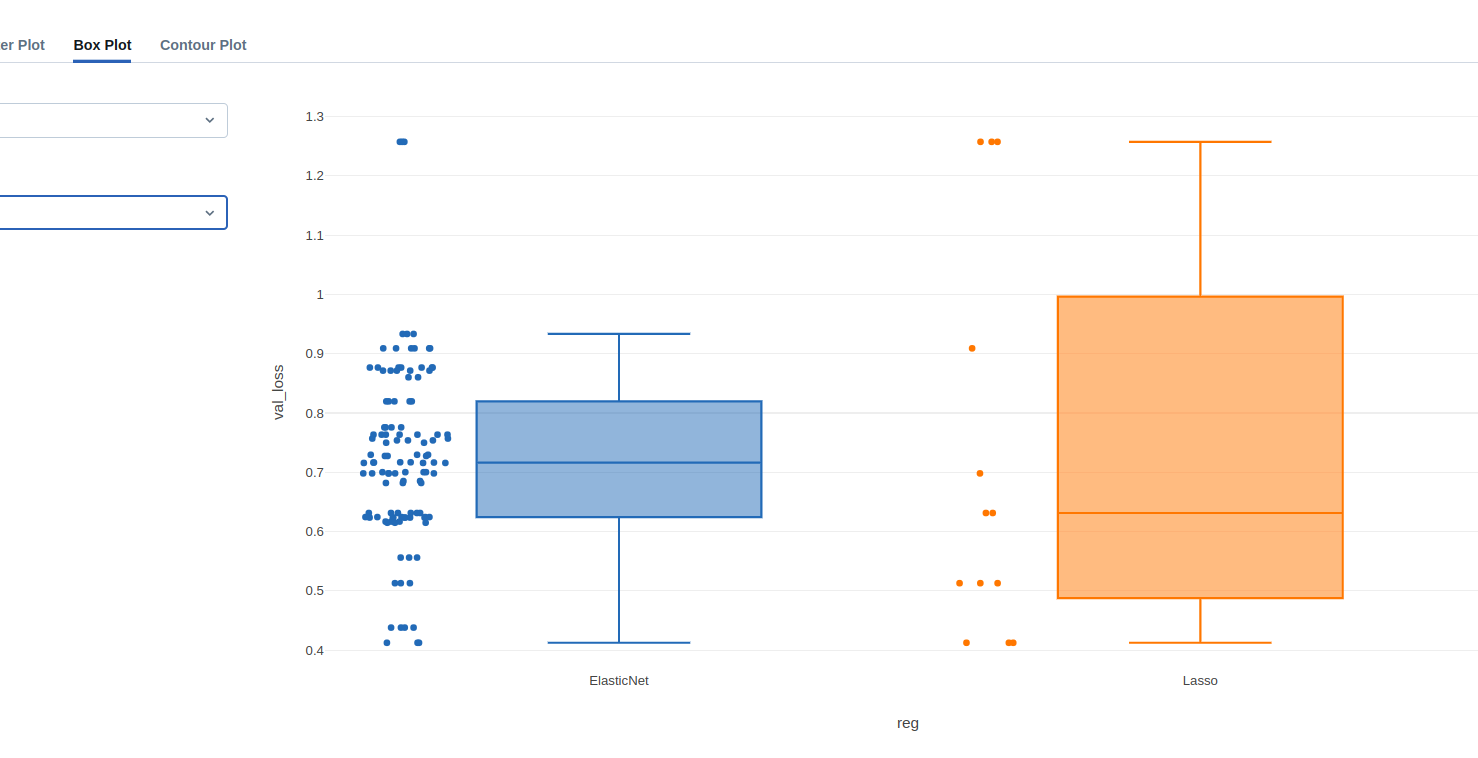

In [41]:
from IPython.display import Image
Image(filename='./Ml_flow_/reg/cla.png')

**<span style="color:blue">cross comparison</span>**
**The class as method('sto') used as stochastic batching for Elasticnet and lasso hav significance in val_loss ElasticNet shows the confience accross the validation samples in contrast**

**compare with higher order polynomials**

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
a = [0.1,10]
coef = []
models = []
for i in a:
    poly_model = Pipeline([
    ("poly", PolynomialFeatures(3, interaction_only=True)),
    ("Linear_regressor", Ridge(alpha = i))])
    model=poly_model.fit(train, x_target)
    models.append(model)
    coef.append(model.named_steps['Linear_regressor'].coef_)
    scores=cross_val_score(poly_model, train, x_target, cv=5,scoring='r2')
    print(scores)

[0.93170766 0.86651824 0.83424582 0.91125619 0.9244264 ]
[0.95240459 0.8860702  0.82387856 0.91140775 0.92219067]


In [43]:
red=models[0]['Linear_regressor'].fit(train, x_target)
red2=models[1]['Linear_regressor'].fit(train, x_target)
dic = pd.DataFrame({'coef':red.coef_, 'names':train.columns})
dic2 = pd.DataFrame({'coef':red2.coef_, 'names':train.columns})


<Axes: xlabel='coef', ylabel='names'>

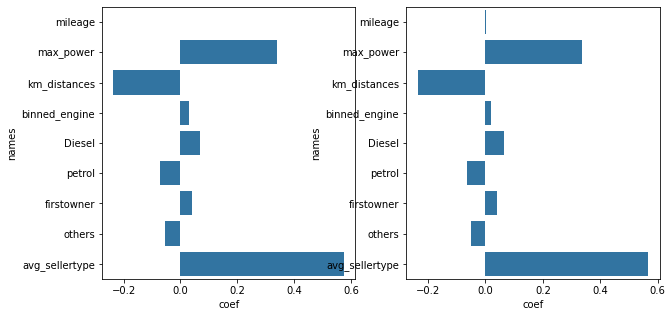

In [44]:
fig, ax =plt.subplots(1,2, figsize=(10,5))
sns.barplot(data = dic, x = 'coef', y = 'names', ax=ax[0])
sns.barplot(data = dic2, x = 'coef', y = 'names', ax=ax[1])

**here features are more or less the same as linear regression except mileage**

In [46]:
tt = train.drop(columns = {'petrol'})

# Final Insights

**The most compelling thing was that there was no variation in the features accross Regularizers, with given data. Tried multiple methods  , reducing number of feature and multiple batching.One of the finding is by looking at correlation plot Diesel and petrol features are highly correlated can impact the score**

In [51]:
from joblib import Parallel, delayed
from statsmodels.stats.outliers_influence import variance_inflation_factor
    
def removeMultiColl(data, vif_threshold = 3.0):
    for i in data.columns:
        if data[i].nunique() == 1:
            print(f"Dropping {i} due to just 1 unique value")
            data.drop(columns = i, inplace = True)
    drop = True
    col_list = list(data.columns)
    while drop == True:
        drop = False
        vif_list = Parallel(n_jobs = -1, verbose = 5)(delayed(variance_inflation_factor)(data[col_list].values, i) for i in range(data[col_list].shape[1]))
        max_index = vif_list.index(max(vif_list))
        if vif_list[max_index] > vif_threshold:
            print(f"Dropping column : {col_list[max_index]} at index - {max_index}")
            del col_list[max_index]
            drop = True
    print("Remaining columns :\n", list(data[col_list].columns))
    return data[col_list]

In [53]:
#final reportx
removeMultiColl(train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    1.4s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    1.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    1.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.0s f

Dropping column : petrol at index - 5
Dropping column : binned_engine at index - 3
Remaining columns :
 ['mileage', 'max_power', 'km_distances', 'Diesel', 'firstowner', 'others', 'avg_sellertype']


,mileage,max_power,km_distances,Diesel,firstowner,others,avg_sellertype
4214,-0.047896,1.838361,0.283850,0,1,0,0.680693
4525,-0.113027,-0.285596,-0.587089,0,1,0,-0.271967
5464,-0.644098,-0.093197,-0.714218,0,1,0,0.680693
3845,-0.644098,2.742948,-3.231589,1,1,0,5.692122
1586,-0.213229,-0.257871,0.324412,0,0,0,-0.271967
...,...,...,...,...,...,...,...
1551,0.588387,0.193302,0.103835,1,0,0,-0.101794
5901,0.355418,-0.091236,-0.143561,1,1,0,-0.102105
320,1.056832,-0.617745,0.525043,1,1,0,-0.412131
4459,-0.588987,0.460477,-0.734443,0,1,0,-0.412131


In [54]:
train.corr()

,mileage,max_power,km_distances,binned_engine,Diesel,petrol,firstowner,others,avg_sellertype
mileage,1.000000,-0.346812,-0.251182,0.547067,0.071650,-0.071650,0.149794,-0.130218,-0.177571
max_power,-0.346812,1.000000,-0.190071,-0.723501,0.310805,-0.310805,0.142201,-0.034785,0.633525
km_distances,-0.251182,-0.190071,1.000000,-0.062913,0.159547,-0.159547,-0.476582,0.261614,-0.323945
binned_engine,0.547067,-0.723501,-0.062913,1.000000,-0.494342,0.494342,-0.010646,-0.009165,-0.438746
Diesel,0.071650,0.310805,0.159547,-0.494342,1.000000,-1.000000,-0.062826,0.008094,0.144982
petrol,-0.071650,-0.310805,-0.159547,0.494342,-1.000000,1.000000,0.062826,-0.008094,-0.144982
firstowner,0.149794,0.142201,-0.476582,-0.010646,-0.062826,0.062826,1.000000,-0.412567,0.121959
others,-0.130218,-0.034785,0.261614,-0.009165,0.008094,-0.008094,-0.412567,1.000000,-0.065092
avg_sellertype,-0.177571,0.633525,-0.323945,-0.438746,0.144982,-0.144982,0.121959,-0.065092,1.000000
